In [1]:
from train import get_model
import yaml

/home/ws/tb0536/anaconda3/lib/python3.7/site-packages/kornia/augmentation/augmentation.py:1875: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  category=DeprecationWarning,
/home/ws/tb0536/anaconda3/lib/python3.7/site-packages/catalyst/registry/registry.py:42: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class Registry(collections.MutableMapping):


In [2]:
import tifffile
import torch
import numpy as np

In [3]:
with open('training_configs/model/eyes_sorting.yaml') as f:
    model_config = yaml.safe_load(f)
model = get_model(**model_config)
# model.load_state_dict(torch.load('/home/ws/tb0536/logs/medaka-supervised/2021-11-04_15-08-47/logdir/checkpoints/best.pth')['model_state_dict'])
model.load_state_dict(torch.load('/home/ws/tb0536/logs/medaka-supervised/2021-11-09_13-39-10/logdir/checkpoints/best.pth')['model_state_dict'])
model = model.train(False)
model = torch.nn.DataParallel(model.to(torch.device('cuda:0')))

>>>>>>>>>>>>>>>> initializing model
trainable parameters in model: 11170755
<<<<<<<<<<<<<<<< done in 0.18 sec.


/home/ws/tb0536/anaconda3/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning:


    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.



In [4]:
from src.augmentations import none_aug
from tqdm.auto import tqdm

In [5]:
import pandas as pd

In [6]:
from glob import glob
import os

In [7]:
# all_possibles = glob('/mnt/LSDF/projects/code-vita/Medaka/2018_11/*/scaled_0.5_8bit_cropped_slices.tif')
all_possibles = glob('/mnt/LSDF/projects/code-vita/Medaka/2018_11/*/scaled_0.5_8bit_slices.tif')

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
def batch_process(volume, batch_size=128):
    predictions = []
    with torch.no_grad():
        for b in range(int(np.ceil(len(volume)/ batch_size))):
            batch = volume[batch_size*b : batch_size*(b+1)]
            batch = none_aug(image=batch)['image']
            batch = torch.from_numpy(batch[:, None, ...])
            batch = batch.to(torch.device('cuda:0'))
            pred = model(batch)
            pred = pred.detach().cpu().numpy()
            predictions.append(pred)
    return np.concatenate(predictions)

In [10]:
from skimage.measure import label

def select_top_k_connected_areas(markup, k):
    connected_regions = label(markup)
    region_id, region_size = np.unique(connected_regions, return_counts=True)
    regions_order = (np.argsort(region_size[1:]) + 1)[::-1] # ordering without zero
    return np.isin(connected_regions, regions_order[:k])

In [11]:
def get_label_boundaries(label_addr):
    label = tifffile.imread(label_addr)
    label_1d = label.sum((1,2)) > 0
    filtered_1d = select_top_k_connected_areas(label_1d, 1)
    filtered_1d = np.where(filtered_1d)[0]
    if len(filtered_1d) > 10:
        return filtered_1d[0], filtered_1d[-1], filtered_1d[int(len(filtered_1d)/2)]
    else:
        return None, None, None

In [18]:
def get_fish_dictionary(img_addr, masks=['liver', 'eyes', 'brain']):
    foldername, filename = os.path.split(img_addr)
    sample_name = foldername.split('/')[-1]
    try:
        _, id, line = sample_name.split('_')[:3]
    except Exception as e:
        print(e)
        return None
    img = tifffile.imread(img_addr)
    scores = batch_process(img, 256)
    labels_bbx = {}
    for label_name in masks:
        labels_bbx[label_name] = get_label_boundaries(os.path.join(foldername, label_name+'_'+filename))
    return {'file_addr': img_addr, 'scores': scores, 'bbx': labels_bbx, 'id': id, 'line': line}

In [20]:
fish_scored_collection = []
for fish_addr in tqdm(all_possibles):
    fd = get_fish_dictionary(fish_addr, ['liver', 'eyes'])
    if fd is not None:
        fish_scored_collection.append(fd)

not enough values to unpack (expected 3, got 2)
not enough values to unpack (expected 3, got 2)
not enough values to unpack (expected 3, got 2)
not enough values to unpack (expected 3, got 2)
not enough values to unpack (expected 3, got 2)
not enough values to unpack (expected 3, got 2)
not enough values to unpack (expected 3, got 2)
not enough values to unpack (expected 3, got 2)
not enough values to unpack (expected 3, got 2)


In [23]:
%%time
fish_collection_to_save = pd.DataFrame(fish_scored_collection)

CPU times: user 6.08 ms, sys: 0 ns, total: 6.08 ms
Wall time: 5.76 ms


In [27]:
fish_collection_to_save.scores = fish_collection_to_save.scores.map(list)

In [29]:
%%time
fish_collection_to_save.to_csv('/mnt/data/machine-learning/medaka_scored_collection.csv')

CPU times: user 1min 4s, sys: 624 ms, total: 1min 5s
Wall time: 1min 4s


In [31]:
def check_localisation(localiser, reference_fish, organ_name):
    errors = []
    for query_fish in fish_scored_collection:
        localisation_error = localiser(reference_fish, query_fish, organ_name)
        errors.append({'error': localisation_error, 'id': query_fish['id'], 'line': query_fish['line']})
    return errors

In [32]:
def ranges_iou(r1, r2):
    intersection = max(0, min(r1[1], r2[1]) - max(r1[0], r2[0]))
    union = (r1[1] - r1[0]) + (r2[1] - r2[0]) - intersection
    if union > 0:
        return intersection/union
    else:
        return None

In [33]:
def proportion_iou_localiser(reference, query, organ_name):
    if reference['bbx'][organ_name][0] is None:
        raise Exception('Having reference fish without boundaries is a way to nowhere!')
    if query['bbx'][organ_name][0] is None:
        return None #no error check possible
    
    # 1. find relative range in reference fish
    far,tar,_ = reference['bbx'][organ_name]
    frr,trr = far/len(reference['scores']), tar/len(reference['scores'])
    # 3. find absolute range in query fish
    predicted_range = frr*len(query['scores']), trr*len(query['scores'])
    faq,taq,_ = query['bbx'][organ_name]
    true_range = (faq, taq)
    # 4. calculate IoU for true -vs- predicted range of query fish
    return ranges_iou(predicted_range, true_range)

In [40]:
def score_iou_localiser(reference, query, organ_name):
    if reference['bbx'][organ_name][0] is None:
        raise Exception('Having reference fish without boundaries is a way to nowhere!')
    if query['bbx'][organ_name][0] is None:
        return None #no error check possible
    
    # 1. find score range in reference fish
    far,tar,_ = reference['bbx'][organ_name]
#     ref_scores = pd.Series(reference['scores'].squeeze()).rolling(20).mean().values
#     que_scores = pd.Series(query['scores'].squeeze()).rolling(20).mean().values
    ref_scores = reference['scores'].squeeze()
    que_scores = query['scores'].squeeze()
    fs,ts = ref_scores[far], ref_scores[tar]
    # 3. find absolute range in query fish
    predicted_area = select_top_k_connected_areas((que_scores > fs) & (que_scores < ts), 1)
    predicted_area = np.where(predicted_area)[0]
    if len(predicted_area) < 10:
        return None
    predicted_range = predicted_area[0], predicted_area[-1]
    faq,taq,_ = query['bbx'][organ_name]
    true_range = (faq, taq)
    # 4. calculate IoU for true -vs- predicted range of query fish
#     plt.plot(reference['scores'])
#     plt.plot(query['scores'])
#     plt.axvline(far, c='r')
#     plt.axvline(tar, c='r')
#     plt.axhline(fs, c='r')
#     plt.axhline(ts, c='r')
#     plt.axvline(predicted_range[0], c='b')
#     plt.axvline(predicted_range[1], c='b')
#     plt.axvline(faq, c='g')
#     plt.axvline(taq, c='g')
    return ranges_iou(predicted_range, true_range)

In [36]:
score_iou_localiser(fish_scored_collection[24], fish_scored_collection[1], 'eyes')

0.3620689655172414

In [41]:
mean_error_score = []
mean_error_prop = []

for reference in np.random.choice(fish_scored_collection, 20):
    mean_error_score += list(pd.DataFrame(check_localisation(score_iou_localiser, reference, 'eyes')).error.values)
    mean_error_prop += list(pd.DataFrame(check_localisation(proportion_iou_localiser, reference, 'eyes')).error.values)

In [42]:
pd.Series(mean_error_score).mean(), pd.Series(mean_error_prop).mean(), 

(0.22638170925247592, 0.24012263000903394)

In [148]:
mean_error_prop/10, mean_error_score/10

(0.36579984653647224, nan)

In [131]:
results = check_localisation(score_iou_localiser, fish_scored_collection[2], 'liver')

In [143]:
pd.DataFrame(results).error.mean()

0.32148444361983186

In [92]:
for i in range(len(triplets)):
    triplets[i]['scores_smooth'] = pd.Series(triplets[i]['scores']).rolling(10, center=True).mean().values

In [110]:
np.nanargmin(np.abs(triplets[1]['scores_smooth'] - triplets[1]['scores_smooth'][reference_id]))

2100

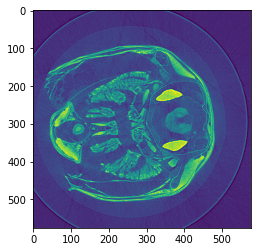

In [113]:
plt.imshow(triplets[1]['img'][2100])

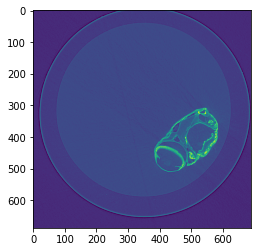

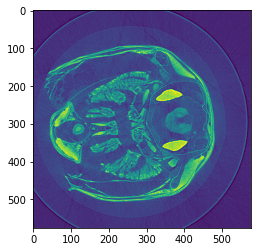

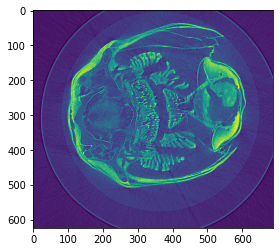

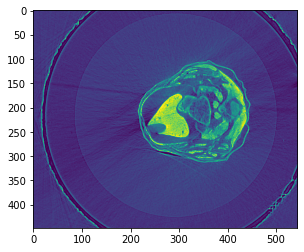

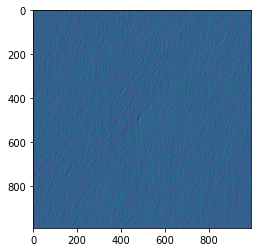

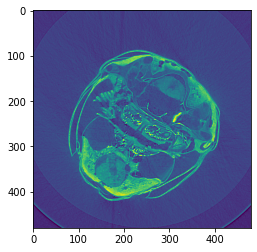

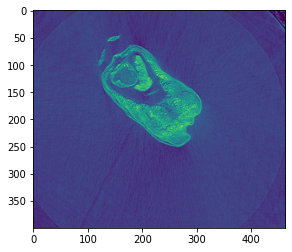

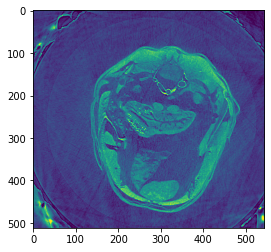

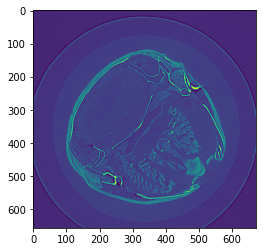

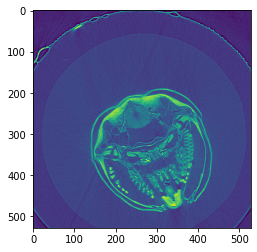

In [111]:
for i in range(10):
#     id = np.abs(triplets[i]['scores'] - triplets[0]['scores'][reference_id]).argmin()
    id = np.nanargmin(np.abs(triplets[i]['scores_smooth'] - triplets[1]['scores_smooth'][reference_id]))
#     id = int((reference_id / len(triplets[0]['scores'])) * len(triplets[i]['scores']))
    plt.imshow(triplets[i]['img'][id])
    plt.show()

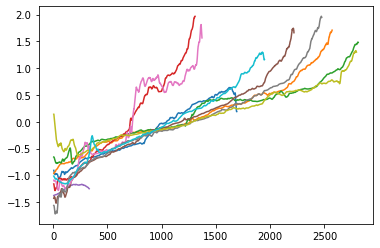

In [94]:
for plete in triplets:
    plt.plot(plete['scores_smooth'])